In [1]:
omega_b = 0.0479; h = 0.6814
scale=0.1452
mean_nb = 1.123e-5/scale**3*omega_b*h**2

In [2]:
print(mean_nb)

8.158675857594528e-05


In [3]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle

In [4]:
def unPackRawFile(raw_path):
    """


    
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    neutral_fraction = []
    real_lyman = []
    gamma = []
    HI = []
    gas_den = []
    real_area_under = []
    temperature = []
    A = []
    which = 0
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1453*3.086e24 /0.68
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        #getting the information about the top point of the peak
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_A = np.divide(gas_density[k],mean_nb)
                            peak_temp = temp[k]
                            peak_gas = gas_density[k]
                            
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    delta_b_plus_one = []
                    for i in range(len(distance)):
                    #calculating the culmulative integral over the peak.
                        if(distance[left_bases]<=distance[i]<= distance[right_bases]):
                            distance_graph.append(distance_cm[i])
                            HI_graph.append(HI_density[i])
                            delta_b_plus_one.append(np.divide(gas_density[i],mean_nb))
                            distance_real.append(distance[i])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    #here we calculate delta_b_plus_one
                    x_int = integrate.cumtrapz(delta_b_plus_one, distance_graph, initial = 0 )
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(y_int[-1] >= (10**16)and y_int[-1]  <= (10**22)):
                        real_lyman.append([y_int,real_distance])
                        real_area_under.append(y_int[-1])
                        neutral_fraction.append(peak_fraction)
                        A.append(peak_A)
                        HI.append(peak_HI)
                        gas_den.append(peak_gas)
                        temperature.append(peak_temp)
                        which = [i,distance[left_bases], distance[right_bases], peak_distance]
    return real_lyman,neutral_fraction,HI,gas_den,which,real_area_under,A,temperature

In [5]:
import numpy as np
real_lyman,neutral_fraction,HI,gas_den,which,real_area_under,A,temperature  = lyman_identification()

In [6]:
A[0]

173.68014427010007

In [7]:
#define T, J_HI
#find all the delta b plus under the two bases, calculate the second derivative
# the delta b plus is just the delta b plus at the peak of the curve
J_HI =1.601e-20

In [8]:
len(temperature)

3155

In [9]:
N_HI = 1.63e13*(np.divide(temperature,10**4))**-0.7*((0.0479*(0.6814**2))/0.0125)**2*(J_HI/0.5)**-1*(((1+5.88)/4)**5)*(2/1.65)**-0.5*A

In [10]:
N_HI

array([3.19861092e+36, 9.27875633e+35, 1.85359888e+36, ...,
       3.27334513e+35, 5.66921803e+35, 5.12270336e+35])

In [11]:
real_area_under

[9.332462167857738e+18,
 1.5659464009464074e+17,
 8.231151058246308e+17,
 3.995345053169995e+16,
 1.9260393193218412e+16,
 2.1538388926436704e+16,
 1.7515774155147118e+16,
 3.1096776254491364e+16,
 8.904719956484101e+19,
 3.3103667271192364e+16,
 9.698837751011053e+16,
 2.8546241597567132e+16,
 3.501101903612829e+17,
 5.341046789531788e+16,
 8.805818834578024e+18,
 6.625832637650506e+16,
 3.291031306760168e+16,
 5.620269448253543e+16,
 3.84486704942416e+16,
 2.511209181393279e+19,
 4.7166490439667704e+16,
 2.5108992872752208e+20,
 2.1825573248229523e+17,
 4.793216253556575e+16,
 1.5603938201415442e+18,
 2.494625305590656e+16,
 1.4876247250937635e+19,
 2.7663768264550695e+19,
 8.58273081967762e+16,
 7.475263420384051e+16,
 3.721910656716712e+16,
 2.05723201753796e+16,
 2.918123407864936e+18,
 5.303090085056248e+16,
 1.0214904719788864e+16,
 5.95073873541968e+17,
 1.906476074327864e+16,
 5.581106822838812e+17,
 1.9965271390808224e+16,
 4.555064375174141e+18,
 1.4889119695362662e+17,
 3.1

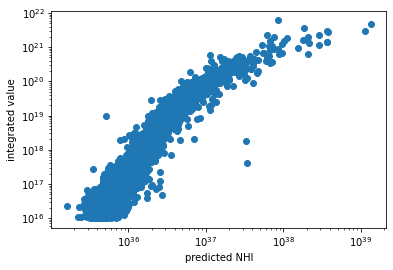

In [12]:
plt.scatter(N_HI,real_area_under)
plt.xlabel("predicted NHI")
plt.ylabel("integrated value")
plt.xscale("log")
plt.yscale("log")